# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.202415,True,4.166583
1,-1.707695,False,-3.310423
2,-0.870345,False,-1.512865
3,0.420172,True,7.067471
4,-0.632547,False,-2.643416
...,...,...,...
995,-0.003463,False,0.634444
996,1.363791,True,8.253146
997,0.238853,True,5.230296
998,0.048037,False,-1.429661


<Axes: xlabel='v0'>

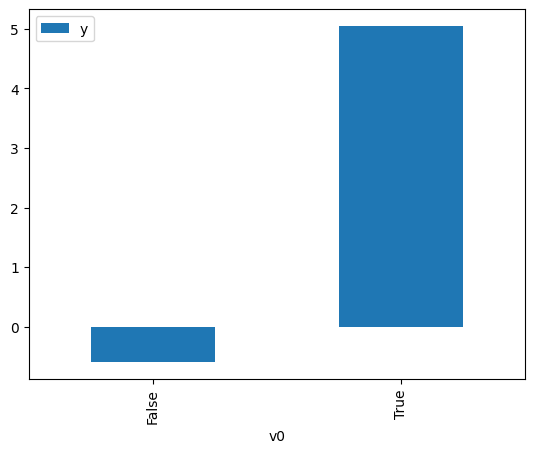

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

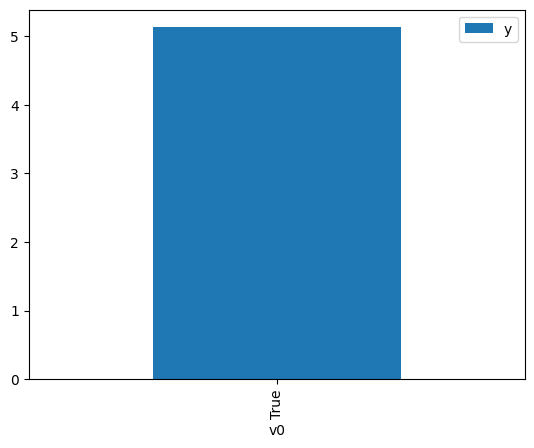

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.404232,False,0.373243,0.736158,1.358404
1,-0.938690,False,-1.235418,0.909454,1.099561
2,-0.263990,False,-1.758825,0.665964,1.501584
3,-0.115231,False,-0.647101,0.582602,1.716437
4,-0.561546,False,-2.164006,0.802678,1.245830
...,...,...,...,...,...
995,1.055050,False,0.652790,0.077898,12.837374
996,0.284657,False,0.700860,0.348664,2.868094
997,-0.565313,False,-2.151018,0.804104,1.243621
998,-0.454122,False,-1.916060,0.758717,1.318014


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.595881,True,1.418882,0.184613,5.416747
1,0.199053,True,6.210000,0.603425,1.657206
2,0.683593,True,5.197494,0.829349,1.205766
3,1.090916,True,9.820027,0.928057,1.077520
4,-0.451915,True,6.011622,0.242252,4.127928
...,...,...,...,...,...
995,1.146688,True,6.148798,0.936487,1.067821
996,0.660479,True,7.776161,0.821365,1.217485
997,-1.219931,True,2.787059,0.048291,20.707865
998,-0.893081,True,3.899021,0.099959,10.004118


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.025e+04
Date:                Tue, 21 May 2024   Prob (F-statistic):                        0.00
Time:                        14:49:53   Log-Likelihood:                         -1415.1
No. Observations:                1000   AIC:                                      2834.
Df Residuals:                     998   BIC:                                      2844.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9859      0.035     56.409      0.000       1.917       2.055
x2             5.0375      0.051     98.720      0.000       4.937       5.138
==============================================================================
Omnibus:                        2.696   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                2.767
Skew:                           0.118   Prob(JB):                        0.251
Kurtosis:                       2.899   Cond. No.                         1.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""